# Text Clustering

## Need datasets are in the current folder structure in the github repo
## Look for 'adjustable' comments to adjust various settings
```
Author: hong cui
Dataset:iSamples
```

In [1]:
from platform import python_version
print(python_version()) #3.9.7

3.9.7


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import fasttext # pip install fasttext-0.9.2-cp310-cp310-win_amd64.whl
import matplotlib.pyplot as plt 
import pickle
from joblib import Parallel, delayed
from sklearn.cluster import Birch
import fastcluster
from scipy.cluster.hierarchy import fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


### Load and preprocess data: selective fields


In [3]:
ds = "OPENCONTEXT"

data = pd.read_csv(ds+'.txt',sep='#', keep_default_na=False)

data.columns.tolist()

df_content = pd.DataFrame()
#adjustable: select different (conbinations) of the files for 'orginal'
df_content['original'] = data['Has type_label'].astype(str)
df_content = df_content.replace(r'^\s*$', np.NaN, regex=True)
df_content.shape[0] #820272
df_content
df_content = df_content.dropna(how='any').reset_index(drop=True)
df_content
df_content.columns
df_content.shape[0] #820272
df_content.iloc[3]
data.iloc[3]




C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2,13,19,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['Has taxonomic identifier_id',
 'Has current location_label',
 'late bce/ce',
 'Has anatomical identification',
 'Has taxonomic identifier_label',
 'Creator_id',
 'Has taxonomic identifier',
 'project uri',
 'Temporal Coverage',
 'citation uri',
 'Has former or current keeper_label',
 'Temporal Coverage_id',
 'Has anatomical identification_id',
 'longitude',
 'updated',
 'Has current location_id',
 'Consists of_id',
 'Has type',
 'Contributor',
 'latitude',
 'Creator_label',
 'Contributor_id',
 'early bce/ce',
 'Has type_label',
 'Has former or current keeper',
 'Has current location',
 'item category',
 'uri',
 'Consists of',
 'Contributor_label',
 'Temporal Coverage_label',
 'context label',
 'Creator',
 'Has former or current keeper_id',
 'Has anatomical identification_label',
 'Has type_id',
 'published',
 'project label',
 'label',
 'Consists of_label',
 'context uri']

820272

,original
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
820267,NaN
820268,NaN
820269,NaN
820270,NaN


,original
0,"Late Roman D(+E?) = (or part) ""Cypriot Red Sli..."
1,Eastern Sigillata A
2,"Late Roman D(+E?) = (or part) ""Cypriot Red Sli..."
3,Late Roman 1 Amphora
4,Eastern Sigillata A
...,...
26516,buttons (fasteners)
26517,panes (architectural elements)
26518,coins (money)
26519,bottles


Index(['original'], dtype='object')

26521

original    Late Roman 1 Amphora
Name: 3, dtype: object

Has taxonomic identifier_id                                                             
Has current location_label                                                              
late bce/ce                                                                        False
Has anatomical identification                                                           
Has taxonomic identifier_label                                                          
Creator_id                                                                              
Has taxonomic identifier                                                                
project uri                            http://opencontext.org/projects/d75ef68a-0e23-...
Temporal Coverage                                                                       
citation uri                                        https://n2t.net/ark:/28722/k2640238w
Has former or current keeper_label                                                      
Temporal Coverage_id 

In [4]:
nltk.download('stopwords')
#adjustable: add collection-specific stop words to the list
estopwords = stopwords.words('english')+["sample", "samples", "sampling", "sampled", "sample_id", "cm"]
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\updates\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import string
def clean(line):
    if pd.isna(line):
        return ''
    else:
        newline =''
        for token1 in re.split(r'#+', line):
            for token2 in token1.split():
                token2 = token2.lower()
                if token2.startswith('https://') or token2.startswith('http://') or re.match(".*?\d.*", token2) or len(token2)<=2 or token2 in estopwords:
                    next
                else:
                    token2 = token2.strip(string.punctuation)
                    for token3 in re.split(r'[/<>.]', token2):
                        if len(token3)<=2 or token3 in estopwords:
                            next
                        else:
                            newline = newline+' '+token3
                        
        return newline.strip()
    
    
# line = "event###records found and at https://wwww.applies.com/###12 cm. l.d. ###width 1dm ###rock>mineral>blue mineral###"    
# line = '""#""#""#""#"74"#""#""#"74"#""#""#""#""#""#""#""#""#"2020"#""#""#"University of Florida"#""#"23.8361515"#""#""#""#""#""#""#"Alpheidae sp. 1"#""#""#""#""#""#"BOMAN_3342"#""#""#""#""#""#"Oman"#""#"NSF_OMAN"#""#""#""#""#""#""#""#""#"OMAN_020A"#""#""#""#"NSF_OMAN"#""#""#""#""#""#""#"1"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"57.9767976"#""#"Event"#""#""#""#""#"Sample"#""#""#""#""#""#""#"in Pocillopora and Acropora rubble"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"Damanyat Islands, S of June Island"#""#""#""#""#""#""#""#""#""#""#""#""#"Abby Uehling"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"74"#""#"Abby Uehling"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"Muscat Governorate"#""#""#"OMAN_020A"#""#"Arthropoda"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""'
# re.split(r'#+', line)
# newline = clean(line)
# newline


plines = list()
%time plines = Parallel(n_jobs=4)(delayed(clean)(line) for line in df_content['original'])

df_content['content'] = plines
df_content = df_content.replace(r'^\s*$', np.NaN, regex=True)
df_content.shape[0] #820272
df_content.drop_duplicates(subset='content', ignore_index=True, inplace=True) #remove redundant rows
df_content = df_content.dropna(how='any').reset_index(drop=True)
df_content.shape[0] #8426
df_content['src'] = ds #add src
plines = df_content['content']
print(plines[0:5])

Wall time: 1.16 s


26521

364

0    late roman d(+e part cypriot red slip ware
1                             eastern sigillata
2                            late roman amphora
3                                         plate
4                                    akroterion
Name: content, dtype: object


## Form the dataset: use pre-trained word vectors to obtain sentence vector for our corpus 
wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz



In [6]:
%time model = fasttext.load_model('../cc.en.300.bin') #takes 7GB

Wall time: 10.2 s


In [7]:
vlines = list() #records represented as vectors
for pline in plines:
    vlines.append(model.get_sentence_vector(pline))

#normalize to unit vector
vlines = normalize(vlines, axis=1)
del model #reclaim memory




## Estimate number of clusters


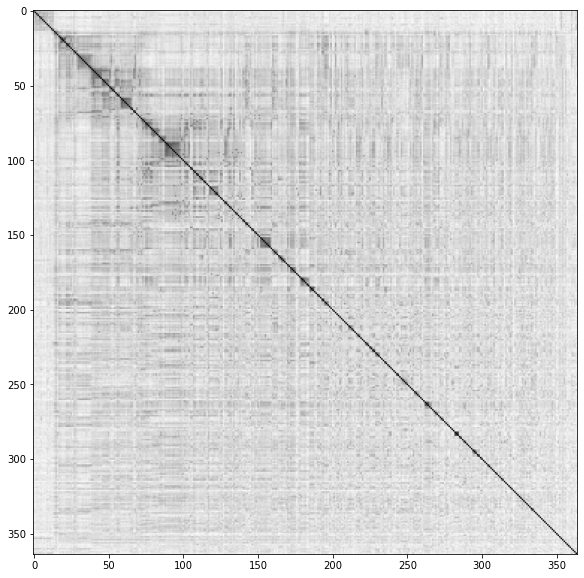

In [8]:
from pyclustertend import vat

#1000 and 5000 samples give very similar vat graph.
#adjustable: len count adjustable, but when it is greater than 3000, it will take time to draw a vat
if len(vlines) > 2000:
    samples = vlines[np.random.choice(vlines.shape[0], 2000, replace=False), :]
    vat(samples) #take data matrix, not dist matrix
else:
    vat(vlines)

## BIRCH clustering: upper level raw clustering 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

In [9]:
#adjustable: all three parameters are adjustable. 
#branching_factor: greater gives more natural cluatering results
#n_clusters: total clusters to output. If set to None, subclusters will be returned directly (and not merged into clusters)
#threshold: Euclidean distance threshold for merging subclusters. Sensitive. Set n_clusters to None and experiment with 0.5, 0.55, etc. to observe the number of subclusters generated.


brc = Birch(branching_factor=200, n_clusters=10, threshold=0.5) #n_clusters = None, meaning unlimited  
%time brc.fit(vlines) 

brc.subcluster_labels_






Wall time: 22 ms


Birch(branching_factor=200, n_clusters=10)

array([5, 5, 8, 8, 1, 5, 5, 4, 3, 0, 5, 8, 2, 5, 5, 4, 7, 3, 5, 5, 4, 3,
       5, 3, 3, 5, 5, 5, 3, 1, 5, 7, 7, 2, 7, 6, 1, 2, 0, 7, 0, 0, 0, 3,
       0, 3, 2, 3, 8, 0, 0, 0, 7, 0, 0, 8, 7, 0, 2, 0, 8, 7, 0, 4, 0, 8,
       4, 0, 0, 6, 7, 0, 9, 2, 1, 8, 0, 3, 4, 3, 8, 9, 0, 9, 8, 2, 0, 6,
       7, 3, 3, 4, 3, 1, 1, 9, 1, 0, 1, 4, 4, 1, 0, 3, 7, 2, 9, 9, 8, 9,
       6, 2, 4, 2, 9, 4, 0, 0, 0, 2, 9, 1, 4, 7, 0, 2, 4, 7, 0, 0, 8, 9,
       0, 2, 0, 0, 3, 3, 1, 0, 8, 7, 8, 1, 8, 2, 2, 7, 2, 9, 7, 0, 2, 4,
       4, 4, 0, 4, 9, 4, 2, 0, 3, 6, 1, 4, 2, 2, 0, 4, 2, 6, 1, 4, 0, 9,
       6, 4, 4, 4, 2, 0, 1, 1, 0, 4, 1, 9, 9, 6, 0, 3, 3, 1, 9, 3, 3, 3,
       1, 1, 0, 2, 7, 6, 3, 3, 0, 7, 3, 2, 4, 4, 8, 3, 2, 2, 2, 7, 2, 6,
       2, 0, 4, 9, 1, 2, 3, 2, 0], dtype=int64)

In [10]:
labels = brc.predict(vlines)
df = pd.DataFrame({'src':df_content['src'], 'birchcluster':labels, 'content':plines, 'original':df_content['original']}) 
df #output variable, global
tab = df.groupby(['src', 'birchcluster']).size()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(tab.unstack().transpose())
    


,src,birchcluster,content,original
0,OPENCONTEXT,7,late roman d(+e part cypriot red slip ware,"Late Roman D(+E?) = (or part) ""Cypriot Red Sli..."
1,OPENCONTEXT,7,eastern sigillata,Eastern Sigillata A
2,OPENCONTEXT,7,late roman amphora,Late Roman 1 Amphora
3,OPENCONTEXT,2,plate,plate
4,OPENCONTEXT,5,akroterion,akroterion
...,...,...,...,...
359,OPENCONTEXT,3,tables support furniture,tables (support furniture)
360,OPENCONTEXT,6,perfume bottles,perfume bottles
361,OPENCONTEXT,2,anchor plates,anchor plates
362,OPENCONTEXT,0,pulleys,pulleys


src           OPENCONTEXT
birchcluster             
0                      77
1                      28
2                      44
3                      44
4                      43
5                      17
6                      23
7                      32
8                      22
9                      34


In [11]:
#Gethering terms using TFIDF 

def gatherTerm(cframe, threshold):
    #adjustable: max_df: [0-1] maximal precentage of the documents containing the word, Set to 1 would make all words eligible, 0, no words eligible .
    #min_df: [0-1] minimal precentage of the documents containing the word, Set to 1 would make essentially no words eligible, 0, all words are eligible.
    #max_features: max number of eligible words will be selected to make the tfidf matrix
    #more settings see https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

    tfidf_vectorizer = TfidfVectorizer(max_df = 1, max_features=500, min_df=0, stop_words='english',
                                  use_idf=True)
    try:
        tfidf_matrix = tfidf_vectorizer.fit_transform(cframe['description'])
        terms = tfidf_vectorizer.get_feature_names()
        ordered_index = tfidf_matrix.toarray().argsort()[:, ::-1]

        allterms = []
        for i in range(0, len(cframe)):
            n_terms = []
            for ind in ordered_index[i,]: 
                if tfidf_matrix[i, ind] > threshold:
                    n_terms.append(terms[ind]) 
            allterms.append(n_terms)
        return allterms
        
    except ValueError:#no term obtained from tfidf when all records holds the same set of terms
        return []

In [12]:
#produce terms from Birch clustering result

frame = df[['birchcluster','content']]
frame = frame.rename(columns={'birchcluster':'cluster', 'content':'description'})
cframe =frame.groupby('cluster', as_index = False).agg({'description': ' '.join})
#adjustable: threshold > 0
terms = gatherTerm(cframe, threshold=0.1)
i=0
for term in terms:
    print('cluster '+ str(cframe.iloc[i]['cluster'])+':')
    print(term)
    i = i+1
    print()




cluster 0:
['fasteners', 'hardware', 'jewelry', 'pins', 'balls', 'strap', 'bullets', 'needle', 'shot', 'buckles', 'buttons', 'loom', 'weight', 'hinges', 'bolts']

cluster 1:
['pieces', 'game', 'cap', 'covers', 'badges', 'patches', 'military', 'seal', 'cents', 'marbles', 'hats', 'handles', 'color', 'medal', 'plaque', 'coin', 'money', 'commemorative', 'coins', 'award', 'cent', 'epaulets', 'lifts', 'lid', 'flags', 'dominoes', 'dice', 'die', 'dimes', 'reales', 'kepis', 'sash', 'stamp', 'insignias']

cluster 2:
['plates', 'flat', 'lamps', 'lamp', 'window']

cluster 3:
['genre', 'architectural', 'genres', 'artifacts', 'media', 'religious', 'hierarchy', 'architecture', 'sculpture']

cluster 4:
['footwear', 'knives', 'grooming', 'spear', 'knapsacks', 'pails', 'spoon', 'spoons', 'brushes', 'forks', 'pestle', 'mops', 'boots', 'blade', 'grindstone', 'maintenance', 'flatware', 'pestles', 'toothbrushes', 'sickle', 'shovels', 'shoes', 'shoelaces', 'comb', 'combs', 'scabbards', 'common', 'pocket', 'c

## clustering of subclusters of BIRCH result with parallal programming
https://www.machinelearningplus.com/python/parallel-processing-python/# not working!

https://github.com/yngvem/parallelising-python 

also see https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

https://github.com/mdimura/sparsehc-dm

https://pypi.org/project/fastcluster/

https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html


In [13]:
from fastcluster import linkage_vector
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram


#birchcluster_df: the input observation data (D=300xN)
#birchcluster_number:  cluster number of birchcluster_df in BIRCH result 
#min_obs: minimal observations in birchcluster_df to run hierarichal clustering, must be >=2

def h_clustering_fast(birchcluster_df, birchcluster_number, link_method, min_obs=2 ):
    #dist = pdist(birchcluster_df)
    print(birchcluster_number)
    if len(birchcluster_df) < min_obs:
        return [] 
    else:
        linkage_matrix = fastcluster.linkage_vector(birchcluster_df, link_method) #single, complete, average, weighted, median, centroid, ward
        return linkage_matrix
    
#result = h_clustering_fast(vlines[df.index[df['birchcluster']==0]], 0, 'ward', 20)
#result
    

In [14]:
#birchcluster_df: df holding the birchcluster observation content
#birchcluster_number:  cluster number of birchcluster_df in BIRCH result 
#linkage_matrix: the linkage_matrix for the birchcluster
#t: threshold to obtain clusters from hierarchical clustering for the specified criterion
#criterion: criterion used to obtain clusters

def obtain_h_clusters(birchcluster_df, birchcluster_number, linkage_matrix, t=10, criterion="maxclust"):
    if np.any(linkage_matrix):
        clusters = fcluster(linkage_matrix, t, criterion=criterion) #distance, inconsistency
        num_clusters = len(np.unique(clusters))
        birchcluster_df = birchcluster_df.reset_index()
        cresult = birchcluster_df[['index']]
        cresult['hcluster']= clusters

        records = {'description':df[df['birchcluster']==birchcluster_number].content, 'cluster':clusters, 'birchcluster':birchcluster_number}
        frame = pd.DataFrame(records, columns=['description', 'cluster', 'birchcluster'])
        cframe =frame.groupby('cluster', as_index = True).agg({'description': ' '.join})
        return cresult
    else:
        return []
    
#len(results)
#16 empty
#cresult = obtain_h_clusters(df[df['birchcluster']==3], 3, linkage_matrix=results[3], t=3 if df[df['birchcluster']==3].shape[0] < 100 else 10 , criterion="maxclust")
#cresult
    
       
            


In [15]:

results = []    
#adjustable: linkmethod: single, complete, average, weighted, median, centroid, ward. Not recommend 'single' for samples dataset.
#min_obs >= 2, minimal number of observations in a cluster to form further clusters
%time results = Parallel(n_jobs=8, verbose=1)(delayed(h_clustering_fast)(vlines[df.index[df['birchcluster']==c]], c, 'ward', 2)  for c in range(0, len(df.birchcluster.unique())))
print("# of linkage matrices obtained: "+str(len(results)))

cresultlist = []
#adjustable: t, number of final/leaf clusters from hierarchical clustering
for cresult in Parallel(n_jobs=8,verbose=1)(delayed(obtain_h_clusters)(df[df['birchcluster']==c], c, linkage_matrix=results[c], t=3 if df[df['birchcluster']==c].shape[0] < 100 else 10, criterion='maxclust') for c in range(0, len(df.birchcluster.unique()))):
    cresultlist.append(cresult)

combined = pd.DataFrame()
#concat list of cresult row-wise
for cresult in cresultlist:
    print("cresult:")
    print(cresult)
    combined = pd.concat([combined, cresult], ignore_index=True)

   
combined.set_index('index', inplace=True)
print(df)
df = df.join(combined) 
print(df)

        



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Wall time: 1.01 s
# of linkage matrices obtained: 10
cresult:
    index  hcluster
0      14         3
1      17         3
2      19         3
3      20         2
4      22         3
..    ...       ...
72    319         2
73    334         3
74    338         3
75    345         2
76    362         3

[77 rows x 2 columns]
cresult:
    index  hcluster
0      10         3
1      12         3
2      71         2
3      82         3
4      84         2
5     108         1
6     111         3
7     115         2
8     119         1
9     123         1
10    170         1
11    197         3
12    203         3
13    219         2
14    246         2
15    249         1
16    256         2
17    269         1
18    272         1
19    273         3
20    278         1
21    290         3
22    291         2
23    296         2
24    297         3
25    311         1
26    352         3
27    358         1
cresult:
    index  hcluster
0       3         1
1      13         3
2      24        

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.6s finished


In [16]:
#produce terms from Birch + hierarchical clustering results

df["cluster"] = df["birchcluster"].astype(str) +'-'+ df["hcluster"].astype(str)
frame = df[['cluster','content']]
frame = frame.rename(columns={'content':'description'})
cframe =frame.groupby('cluster', as_index = False).agg({'description': ' '.join})
terms = gatherTerm(cframe, 0.1)
i=0
allterms = list()
for term in terms:
    print('cluster '+cframe.iloc[i]['cluster']+':')
    print(term)
    i = i+1
    print()
    allterms.extend(term)

from collections import Counter
counter = Counter(allterms)
counter.most_common()
        



cluster 0-1:
['fasteners', 'hardware', 'bolts', 'buttons', 'strap', 'hinges', 'buckles']

cluster 0-2:
['jewelry', 'pendant', 'ring', 'brooch', 'hairpins', 'bracelets', 'bead', 'beads', 'pierced']

cluster 0-3:
['bullets', 'balls', 'loom', 'needle', 'shot', 'weight', 'disc', 'shaped', 'toothpicks', 'ball', 'pin', 'tacks', 'tack', 'masses', 'stud', 'minié', 'straight', 'blocks', 'guards', 'funnel', 'peg', 'flywheels', 'spools', 'spool', 'spike', 'sinker', 'rod', 'tie', 'sling', 'whorls', 'wedge', 'weights', 'holders', 'dowel', 'plume', 'hook', 'arrow', 'dowels', 'pulleys', 'plug', 'tube', 'wire', 'trigger']

cluster 1-1:
['pieces', 'game', 'dominoes', 'money', 'coins', 'cents', 'cent', 'marbles', 'reales', 'coin', 'dice', 'die', 'dimes']

cluster 1-2:
['military', 'patches', 'badges', 'insignias', 'flags', 'hats', 'color', 'epaulets', 'kepis']

cluster 1-3:
['covers', 'medal', 'commemorative', 'plaque', 'handles', 'seal', 'lifts', 'lid', 'award', 'stamp', 'sash']

cluster 2-1:
['plates'

[('fasteners', 1),
 ('hardware', 1),
 ('bolts', 1),
 ('buttons', 1),
 ('strap', 1),
 ('hinges', 1),
 ('buckles', 1),
 ('jewelry', 1),
 ('pendant', 1),
 ('ring', 1),
 ('brooch', 1),
 ('hairpins', 1),
 ('bracelets', 1),
 ('bead', 1),
 ('beads', 1),
 ('pierced', 1),
 ('bullets', 1),
 ('balls', 1),
 ('loom', 1),
 ('needle', 1),
 ('shot', 1),
 ('weight', 1),
 ('disc', 1),
 ('shaped', 1),
 ('toothpicks', 1),
 ('ball', 1),
 ('pin', 1),
 ('tacks', 1),
 ('tack', 1),
 ('masses', 1),
 ('stud', 1),
 ('minié', 1),
 ('straight', 1),
 ('blocks', 1),
 ('guards', 1),
 ('funnel', 1),
 ('peg', 1),
 ('flywheels', 1),
 ('spools', 1),
 ('spool', 1),
 ('spike', 1),
 ('sinker', 1),
 ('rod', 1),
 ('tie', 1),
 ('sling', 1),
 ('whorls', 1),
 ('wedge', 1),
 ('weights', 1),
 ('holders', 1),
 ('dowel', 1),
 ('plume', 1),
 ('hook', 1),
 ('arrow', 1),
 ('dowels', 1),
 ('pulleys', 1),
 ('plug', 1),
 ('tube', 1),
 ('wire', 1),
 ('trigger', 1),
 ('pieces', 1),
 ('game', 1),
 ('dominoes', 1),
 ('money', 1),
 ('coins', 1)

In [17]:
#see corresponding content
df [(df['birchcluster']==4) & (df['hcluster']==2)]

,src,birchcluster,content,original,hcluster,cluster
105,OPENCONTEXT,4,utensils,utensils,2,4-2
122,OPENCONTEXT,4,razors,razors,2,4-2
142,OPENCONTEXT,4,pails,pails,2,4-2
169,OPENCONTEXT,4,combs grooming tools,combs (grooming tools),2,4-2
172,OPENCONTEXT,4,jackknives,jackknives,2,4-2
223,OPENCONTEXT,4,shoelaces,shoelaces,2,4-2
226,OPENCONTEXT,4,forks flatware,forks (flatware),2,4-2
227,OPENCONTEXT,4,doorknobs,doorknobs,2,4-2
229,OPENCONTEXT,4,spoons,spoons,2,4-2
232,OPENCONTEXT,4,tools,tools,2,4-2
